# PBR Basecolor Prediction from Rendered Images

## Project Goal

Use deep learning to extract basecolor textures from lit rendered images.

---

## Technical Details

**Input**: Rendered image with lighting (256×256 RGB)  
**Output**: Basecolor texture (256×256 RGB)  
**Model**: U-Net architecture  
**Loss Function**: Perceptual Loss (VGG-based)

---

## Dataset

- 6 different lighting conditions
- Corresponding basecolor textures
- Train/Validation/Test split: 70%/15%/15%

---


### Section 1 Environment Setup and Library Imports


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.models as models
import torchvision.transforms as transforms
from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


torch.manual_seed(42)



# Section 2: Data Handling and Visualization

This section loads the dataset, pairs rendered images with basecolor textures, splits data into train/validation/test sets, and visualizes samples to understand the problem.

### Dataset Structure

- **50 PBR materials**
- **6 lighting conditions per material** → Total 300 rendered images
- **50 basecolor textures** (1 per material)

### Key Idea

Train with 6 different lighting conditions so the model learns to extract basecolor under any lighting scenario.


#### Download Dataset

In [3]:
import os
import sys

# Install gdown if not available
try:
    import gdown
except ImportError:
    print("Installing gdown...")
    import subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "gdown"])
    import gdown

# Download dataset
file_id = '1nvk5kZS5P9aeN6mB8CWD-a-81KYX5zl8'
url = f'https://drive.google.com/uc?id={file_id}'

print("Downloading dataset...")
gdown.download(url, 'dataset.zip', quiet=False)

# Extract
import zipfile
zipfile.ZipFile("dataset.zip").extractall("data")

print("Done")



Downloading...
From (original): https://drive.google.com/uc?id=1nvk5kZS5P9aeN6mB8CWD-a-81KYX5zl8
From (redirected): https://drive.google.com/uc?id=1nvk5kZS5P9aeN6mB8CWD-a-81KYX5zl8&confirm=t&uuid=51a57d0e-a267-4b82-a91f-d3a97f12bc84
To: /home/s5820023/Desktop/test/dataset.zip
100%|█████████████████████████████████████████████████████████████████████████████| 556M/556M [00:05<00:00, 100MB/s]


Done


#### 2.1 Dataset Class with Data Augmentation
For ease of demonstration, the contents of src.dataset are provided below. You can complete the dataset definition either by importing or directly running the code below. 

In [11]:
from src.dataset import PBRBasecolorDataset

In [12]:
class PBRBasecolorDataset(Dataset):
 
    def __init__(self, raw_dirs, basecolor_dir, image_size=256, augment=False):
        self.basecolor_dir = Path(basecolor_dir)
        self.image_size = image_size
        self.augment = augment  
        
        # Collect all rendered images from 6 lighting folders
        self.raw_files = []
        for raw_dir in raw_dirs:
            raw_path = Path(raw_dir)
            files = sorted(raw_path.glob("*.jpg")) + sorted(raw_path.glob("*.png"))
            files += sorted(raw_path.glob("*.JPG")) + sorted(raw_path.glob("*.PNG"))
            self.raw_files.extend(files)
        
        self.basecolor_files = []
        for raw_file in self.raw_files:

            import re
            basecolor_name = re.sub(r'_Raw_L\d+', '_Color', raw_file.name)
            basecolor_file = self.basecolor_dir / basecolor_name
            self.basecolor_files.append(basecolor_file)
    
    def __len__(self):
        return len(self.raw_files)
    
    def __getitem__(self, idx):
        raw_img = Image.open(self.raw_files[idx]).convert("RGB")
        basecolor_img = Image.open(self.basecolor_files[idx]).convert("RGB")
        

        raw_img = raw_img.resize((self.image_size, self.image_size), Image.LANCZOS)
        basecolor_img = basecolor_img.resize((self.image_size, self.image_size), Image.LANCZOS)
        
        
        if self.augment:
            if torch.rand(1) > 0.5:
                raw_img = raw_img.transpose(Image.FLIP_LEFT_RIGHT)
                basecolor_img = basecolor_img.transpose(Image.FLIP_LEFT_RIGHT)
            
            if torch.rand(1) > 0.5:
                angle = torch.randint(1, 4, (1,)).item() * 90  # 90, 180, or 270
                raw_img = raw_img.rotate(angle)
                basecolor_img = basecolor_img.rotate(angle)
       
        

        transform = transforms.ToTensor()
        raw_tensor = transform(raw_img)
        basecolor_tensor = transform(basecolor_img)
        
        return raw_tensor, basecolor_tensor



#### 2.2 Create dataset

In [14]:
raw_dirs = [
    "data/raw_light1",
    "data/raw_light2", 
    "data/raw_light3",
    "data/raw_light4",
    "data/raw_light5",
    "data/raw_light6",
]

dataset = PBRBasecolorDataset(
    raw_dirs=raw_dirs,
    basecolor_dir="data/basecolor",
    image_size=256
)

print(f"Dataset size: {len(dataset)}")
print(f"Expected: 50 materials × 6 lightings = 300")


Dataset size: 300
Expected: 50 materials × 6 lightings = 300


#### 2.3 Visualize Data Augmentation Effect

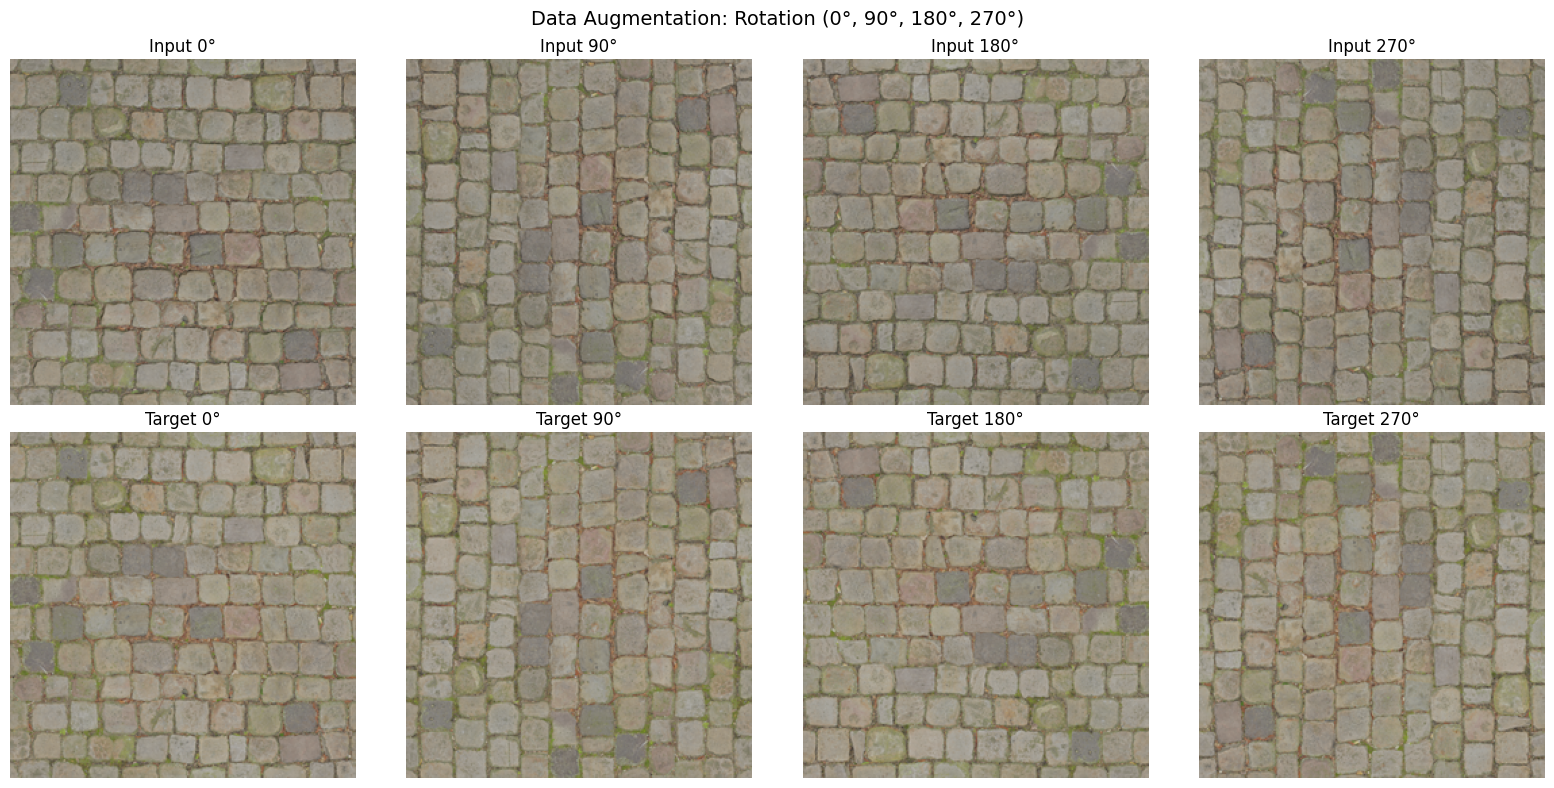

In [15]:
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

idx = 15 

raw_original, basecolor_original = dataset[idx]

from torchvision import transforms
to_pil = transforms.ToPILImage()
to_tensor = transforms.ToTensor()

raw_pil = to_pil(raw_original)
basecolor_pil = to_pil(basecolor_original)

angles = [0, 90, 180, 270]
for i, angle in enumerate(angles):

    raw_rotated = raw_pil.rotate(angle)
    basecolor_rotated = basecolor_pil.rotate(angle)
    
    raw_tensor = to_tensor(raw_rotated)
    basecolor_tensor = to_tensor(basecolor_rotated)
    
    axes[0, i].imshow(raw_tensor.permute(1, 2, 0))
    axes[0, i].set_title(f"Input {angle}°")
    axes[0, i].axis('off')
    
    axes[1, i].imshow(basecolor_tensor.permute(1, 2, 0))
    axes[1, i].set_title(f"Target {angle}°")
    axes[1, i].axis('off')

plt.suptitle("Data Augmentation: Rotation (0°, 90°, 180°, 270°)", fontsize=14)
plt.tight_layout()
plt.show()



#### 2.4 Split dataset: 70% / 15% / 15%

In [46]:
train_size = int(0.7 * len(dataset))  # 210
val_size = int(0.15 * len(dataset))   # 45
test_size = len(dataset) - train_size - val_size  # 45

# Split 
train_dataset, val_dataset, test_dataset = random_split(
    dataset,
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)


train_dataset_augmented = PBRBasecolorDataset(
    raw_dirs=raw_dirs,
    basecolor_dir="data/basecolor",
    image_size=256,
    augment=True  # Only training set uses augmentation
)
train_dataset = torch.utils.data.Subset(train_dataset_augmented, train_dataset.indices)


print(f"Train: {len(train_dataset)} (with augmentation)")
print(f"Validation: {len(val_dataset)} (no augmentation)")
print(f"Test: {len(test_dataset)} (no augmentation)")


Train: 210 (with augmentation)
Validation: 45 (no augmentation)
Test: 45 (no augmentation)


#### 2.5 Create DataLoader

In [17]:
batch_size = 8

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Batch size: {batch_size}")
print(f"Train batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")


Batch size: 8
Train batches: 27
Validation batches: 6
Test batches: 6


#### 2.6 Visualization

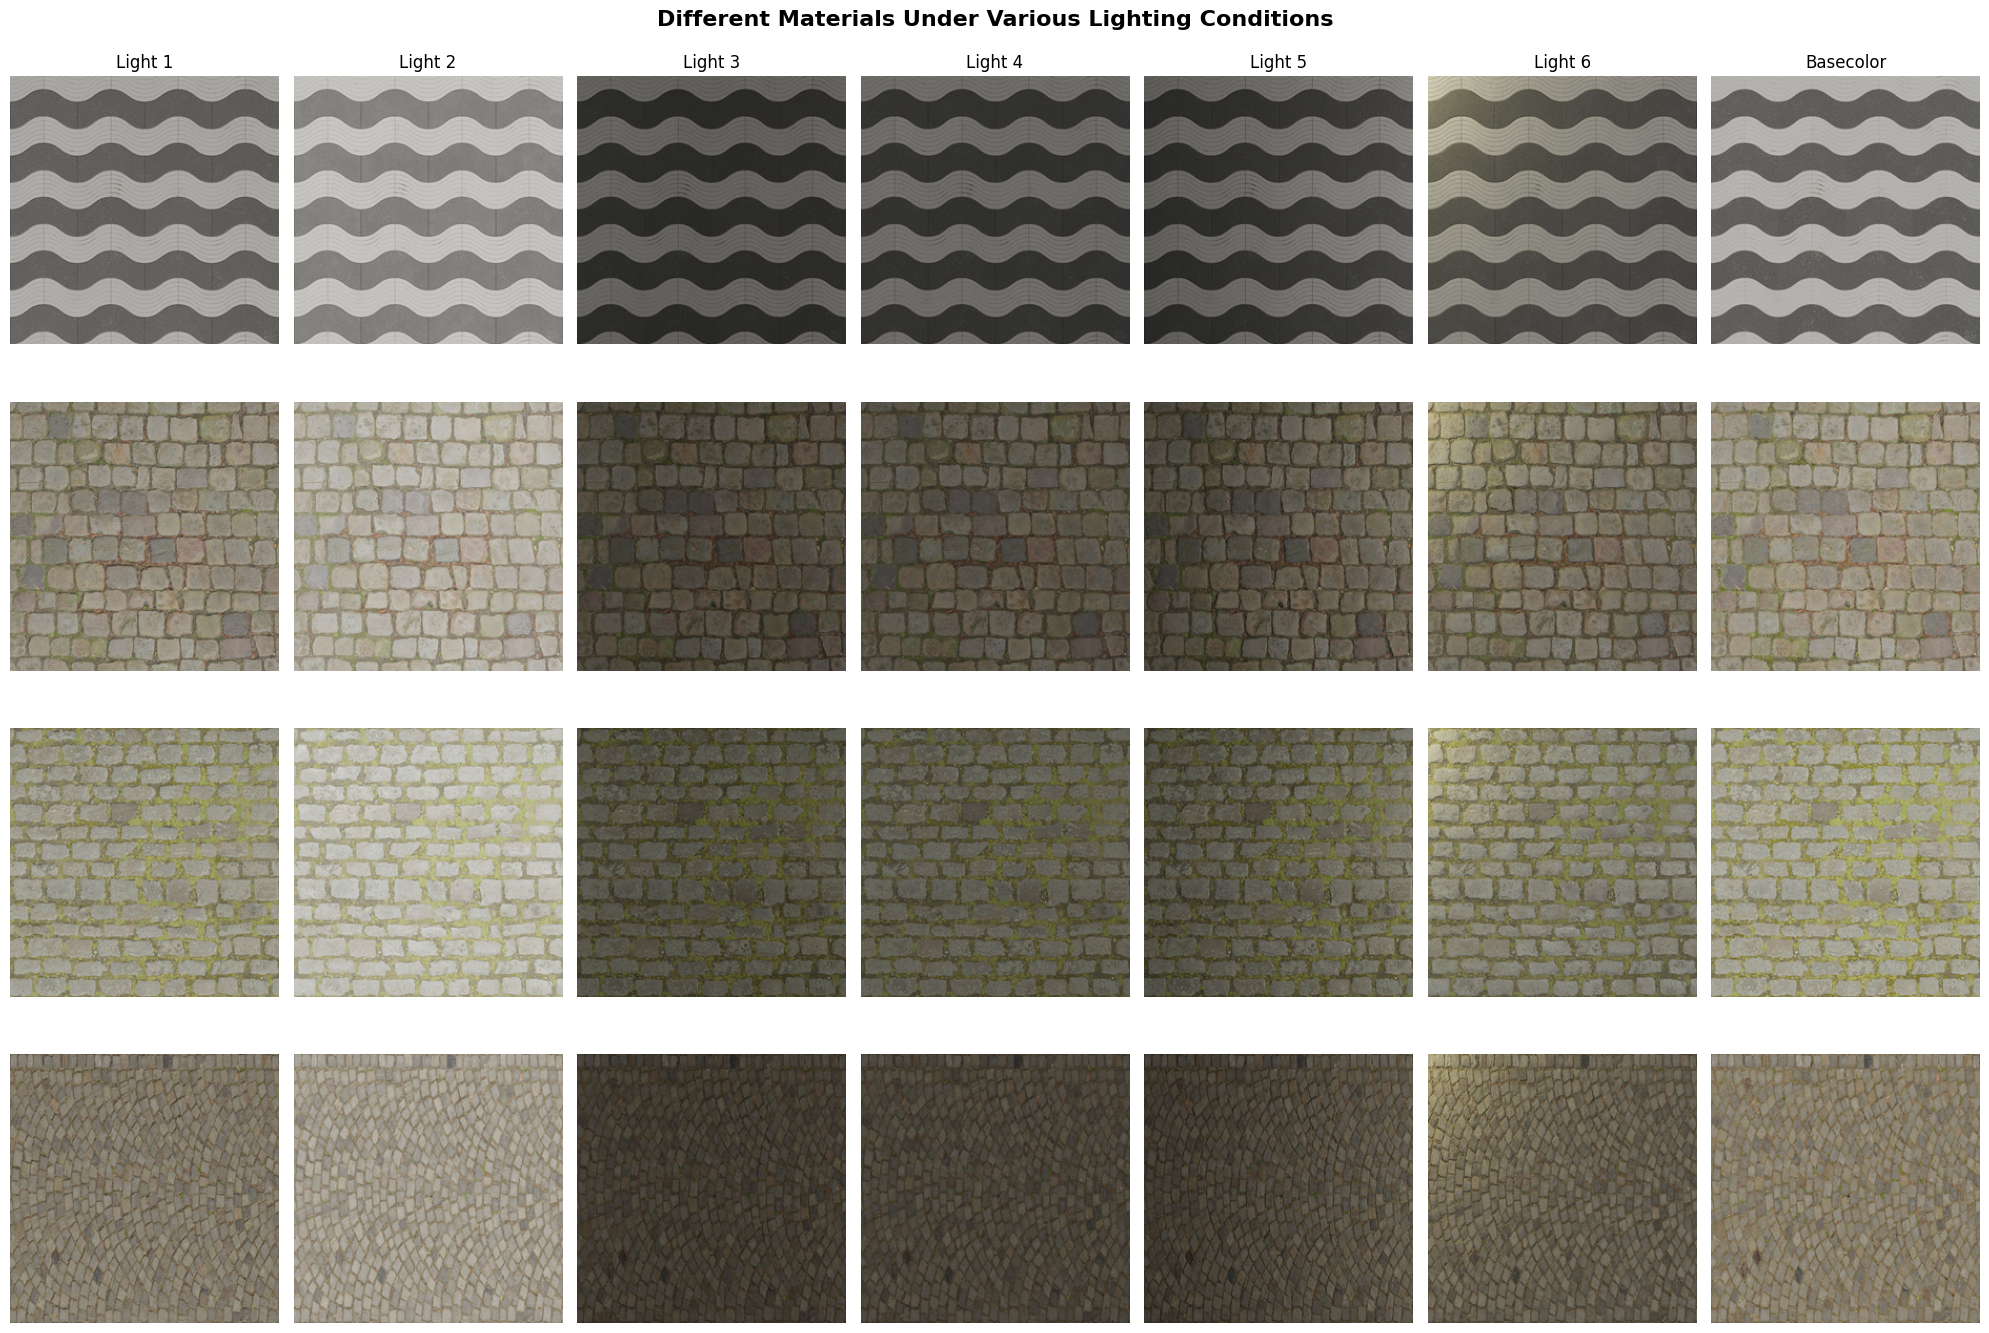

In [47]:
material_indices = [0, 15, 30, 49]

raw_dirs = ["data/raw_light1", "data/raw_light2", "data/raw_light3", 
            "data/raw_light4", "data/raw_light5", "data/raw_light6"]

fig, axes = plt.subplots(len(material_indices), 7, figsize=(20, 3.5 * len(material_indices)))
fig.suptitle('Different Materials Under Various Lighting Conditions', fontsize=16, fontweight='bold')

for row_idx, material_idx in enumerate(material_indices):
    for light_idx, raw_dir in enumerate(raw_dirs):
        img_file = sorted(Path(raw_dir).glob("*.png"))[material_idx]
        img = Image.open(img_file).convert("RGB").resize((256, 256), Image.LANCZOS)
        
        axes[row_idx, light_idx].imshow(np.array(img) / 255.0)
        if row_idx == 0:
            axes[row_idx, light_idx].set_title(f'Light {light_idx + 1}')
        axes[row_idx, light_idx].axis('off')
    
    basecolor_file = sorted(Path("data/basecolor").glob("*.png"))[material_idx]
    basecolor = Image.open(basecolor_file).convert("RGB").resize((256, 256), Image.LANCZOS)
    
    axes[row_idx, 6].imshow(np.array(basecolor) / 255.0)
    if row_idx == 0:
        axes[row_idx, 6].set_title('Basecolor')
    axes[row_idx, 6].axis('off')
    
    axes[row_idx, 0].set_ylabel(f'Mat {material_idx + 1}', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()


## Section 3: Model Architecture

This section builds a U-Net neural network to learn the mapping from lit images to pure basecolor textures.

### U-Net Architecture:

1. **Encoder**: Gradually downsample images through convolution and pooling to extract abstract features
     
2. **Bottleneck**: Capture the most essential feature information at the lowest resolution
     
3. **Decoder**: Gradually restore image size through upsampling to reconstruct details
     
4. **Skip Connection**: Pass high-resolution features from encoder to decoder to preserve details

### Model Configuration:

- 4-layer encoder structure (deeper network)
- base_channels=64 (larger feature capacity)
- Enhanced feature extraction and reconstruction capability


#### 3.1 Improved U-Net Network
For ease of demonstration, the contents of src.model are provided below. You can complete the model definition either by importing or directly running the code below.

In [28]:
from src.model import SimpleUNet

In [29]:
class SimpleUNet(nn.Module):

    
    def __init__(self, in_channels=3, out_channels=3, base_channels=64):
        super().__init__()
        
        # Encoder
        self.enc1 = self._block(in_channels, base_channels)           # 3 → 64 
        self.enc2 = self._block(base_channels, base_channels * 2)     # 64 → 128 
        self.enc3 = self._block(base_channels * 2, base_channels * 4) # 128 → 256 
        self.enc4 = self._block(base_channels * 4, base_channels * 8) # 256 → 512 
        
        # Bottleneck
        self.bottleneck = self._block(base_channels * 8, base_channels * 16)  # 512 → 1024 
        
        # Decoder
        self.dec4 = self._block(base_channels * 16 + base_channels * 8, base_channels * 8)  # (1024+512) → 512
        self.dec3 = self._block(base_channels * 8 + base_channels * 4, base_channels * 4)   # (512+256) → 256
        self.dec2 = self._block(base_channels * 4 + base_channels * 2, base_channels * 2)   # (256+128) → 128
        self.dec1 = self._block(base_channels * 2 + base_channels, base_channels)           # (128+64) → 64
        
        # Output layer
        self.out_conv = nn.Conv2d(base_channels, out_channels, kernel_size=1)
    
    def _block(self, in_c, out_c):
        
        return nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=3, padding=1, bias=False),  
            nn.BatchNorm2d(out_c),                                          
            nn.ReLU(inplace=True),                                          
            nn.Conv2d(out_c, out_c, kernel_size=3, padding=1, bias=False), 
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
        )
    
    def forward(self, x):
        
        #  Encoder 
        enc1_out = self.enc1(x)                          # [B, 64, 256, 256] 
        enc2_out = self.enc2(F.max_pool2d(enc1_out, 2))  # [B, 128, 128, 128]
        enc3_out = self.enc3(F.max_pool2d(enc2_out, 2))  # [B, 256, 64, 64] 
        enc4_out = self.enc4(F.max_pool2d(enc3_out, 2))  # [B, 512, 32, 32] 
        
        # Bottleneck
        bottleneck_out = self.bottleneck(F.max_pool2d(enc4_out, 2))  # [B, 1024, 16, 16] 
        
        # Decoder 
        
        # Decoder level 4
        up4 = F.interpolate(bottleneck_out, scale_factor=2, mode="bilinear", align_corners=False)
        up4 = torch.cat([up4, enc4_out], dim=1)  
        dec4_out = self.dec4(up4)                # [B, 512, 32, 32]
        
        # Decoder level 3
        up3 = F.interpolate(dec4_out, scale_factor=2, mode="bilinear", align_corners=False)
        up3 = torch.cat([up3, enc3_out], dim=1)
        dec3_out = self.dec3(up3)                # [B, 256, 64, 64]
        
        # Decoder level 2
        up2 = F.interpolate(dec3_out, scale_factor=2, mode="bilinear", align_corners=False)
        up2 = torch.cat([up2, enc2_out], dim=1)
        dec2_out = self.dec2(up2)                # [B, 128, 128, 128]
        
        # Decoder level 1
        up1 = F.interpolate(dec2_out, scale_factor=2, mode="bilinear", align_corners=False)
        up1 = torch.cat([up1, enc1_out], dim=1)
        dec1_out = self.dec1(up1)                # [B, 64, 256, 256]
        
        # Output layer
        out = self.out_conv(dec1_out)            # [B, 3, 256, 256]
        
        return out


#### 3.2 Test model

In [11]:
model = SimpleUNet(in_channels=3, out_channels=3, base_channels=64)
test_input = torch.randn(1, 3, 256, 256)
test_output = model(test_input)

print(f" Model test successful")
print(f" Input: {test_input.shape}")
print(f" Output: {test_output.shape}")
print(f" Parameters: {sum(p.numel() for p in model.parameters()):,}")


 Model test successful
 Input: torch.Size([1, 3, 256, 256])
 Output: torch.Size([1, 3, 256, 256])
 Parameters: 31,384,963


## Section 4: Perceptual Loss 

This section implements a Perceptual Loss function using VGG16 features to make predictions look more realistic.

### Perceptual Loss

- **Regular MSE**: Only compares pixel values → blurry results
- **Perceptual Loss**: Compares high-level features (texture, structure) → sharper, more natural results

### Implementation Steps

1. Build PerceptualLoss module using pretrained VGG16
2. Test the loss function with sample data
3. Compare MSE vs Perceptual Loss visually



#### 4.1 PerceptualLoss Class
    Perceptual loss using pretrained VGG16 for feature extraction
    
    How it works:
    - Extract deep features from VGG16 (trained on ImageNet)
    - Compare features between prediction and target
    - Combine with pixel-level loss for better results

In [ ]:
from 

In [30]:
class PerceptualLoss(nn.Module):
    def __init__(self):
        super().__init__()
        
        vgg = models.vgg16(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(vgg.features)[:16]).eval()
        
        for param in self.feature_extractor.parameters():
            param.requires_grad = False
        
        self.l1_loss = nn.L1Loss()      
        self.mse_loss = nn.MSELoss()    
    
    def forward(self, pred, target):
        
        # Pixel-level loss
        pixel_loss = 0.5 * self.l1_loss(pred, target) + 0.5 * self.mse_loss(pred, target)
        
        # Perceptual loss
        pred_features = self.feature_extractor(pred)
        target_features = self.feature_extractor(target)
        perceptual_loss = self.mse_loss(pred_features, target_features)
        
        # Combine
        total_loss = 0.3 * pixel_loss + 0.7 * perceptual_loss
        
        return total_loss




#### 4.2 Initialize loss function

In [13]:
criterion = PerceptualLoss()

pred = torch.randn(2, 3, 256, 256)      
target = torch.randn(2, 3, 256, 256)    

loss = criterion(pred, target)

print(f"Unit test passed")
print(f"Loss value: {loss.item():.4f}")


/home/s5820023/.pyenv/versions/3.13.11/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/s5820023/.pyenv/versions/3.13.11/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Unit test passed
Loss value: 4.5746


#### 4.3 Create sample images for comparison

In [17]:
sample_pred = torch.randn(1, 3, 256, 256)
sample_target = torch.randn(1, 3, 256, 256)

# Calculate different losses
mse_criterion = nn.MSELoss()
perceptual_criterion = PerceptualLoss()

mse_loss = mse_criterion(sample_pred, sample_target)
perceptual_loss = perceptual_criterion(sample_pred, sample_target)


print(f"MSE Loss: {mse_loss.item():.4f}")
print(f"Perceptual Loss: {perceptual_loss.item():.4f}")


MSE Loss: 1.9990
Perceptual Loss: 4.5899


# Section 5: Training and Validation

This section trains the U-Net model using perceptual loss, monitors training/validation loss, logs training progress, and visualizes prediction results during training.

### Training Configuration:

- **Optimizer**: Adam with learning rate 0.001
- **Learning Rate Scheduler**: Reduce on plateau
- **Loss Function**: Perceptual Loss (VGG-based)
- **Epochs**: 200
- **Logging**: Save training logs to file

### Key Features:

- Real-time loss monitoring
- Validation result visualization every 10 epochs
- Automatic learning rate adjustment
- Training log recording

#### 5.1 Training configuration

In [56]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

num_epochsnum_epochs = 150 # Number of training epochs
learning_rate = 1e-4 # Learning rate for optimizer
checkpoint_dir = Path("checkpoints") # Directory to save model checkpoints
checkpoint_dir.mkdir(exist_ok=True) # Create directory if not exists 

model = SimpleUNet(in_channels=3, out_channels=3, base_channels=64).to(device) # Initialize U-Net model and move to device
criterion = PerceptualLoss().to(device)# Perceptual loss function for better visual quality
optimizer = optim.Adam(model.parameters(), lr=learning_rate)# Adam optimizer for training
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)# Reduce learning rate when loss plateaus


print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")


Device: cuda
Model parameters: 31,384,963


#### 5.2 Training loop

In [57]:
best_val_loss = float('inf')
train_losses = []
val_losses = []

print(f"Total epochs: {num_epochs}")
print(f"Progress will be shown every 20 epochs\n")

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    
    for raw, basecolor in train_loader:
        raw = raw.to(device)
        basecolor = basecolor.to(device)
        
        optimizer.zero_grad()
        output = model(raw)
        loss = criterion(output, basecolor)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validation Phase
    model.eval()
    val_loss = 0.0
    
    with torch.no_grad():
        for raw, basecolor in val_loader:
            raw = raw.to(device)
            basecolor = basecolor.to(device)
            
            output = model(raw)
            loss = criterion(output, basecolor)
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    
    scheduler.step(avg_val_loss)
    
    # Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': avg_train_loss,
            'val_loss': avg_val_loss,
        }, checkpoint_dir / 'best_model.pth')
    
    # Print every 20 epochs
    if (epoch + 1) % 20 == 0 or epoch == 0 or epoch == num_epochs - 1:
        saved_mark = "✓" if avg_val_loss == best_val_loss else " "
        print(f"{saved_mark} Epoch {epoch+1:3d}/{num_epochs} | "
              f"Train: {avg_train_loss:.4f} | Val: {avg_val_loss:.4f} | "
              f"Best: {best_val_loss:.4f}")


Total epochs: 150
Progress will be shown every 20 epochs

✓ Epoch   1/150 | Train: 1.6577 | Val: 1.5494 | Best: 1.5494
✓ Epoch  20/150 | Train: 0.3188 | Val: 0.3643 | Best: 0.3643
  Epoch  40/150 | Train: 0.2894 | Val: 0.3445 | Best: 0.3375
  Epoch  60/150 | Train: 0.2736 | Val: 0.3355 | Best: 0.3255
  Epoch  80/150 | Train: 0.2652 | Val: 0.3215 | Best: 0.3198
  Epoch 100/150 | Train: 0.2672 | Val: 0.3205 | Best: 0.3165
  Epoch 120/150 | Train: 0.2549 | Val: 0.3195 | Best: 0.3146
  Epoch 140/150 | Train: 0.2445 | Val: 0.3149 | Best: 0.3118
  Epoch 150/150 | Train: 0.2484 | Val: 0.3161 | Best: 0.3118


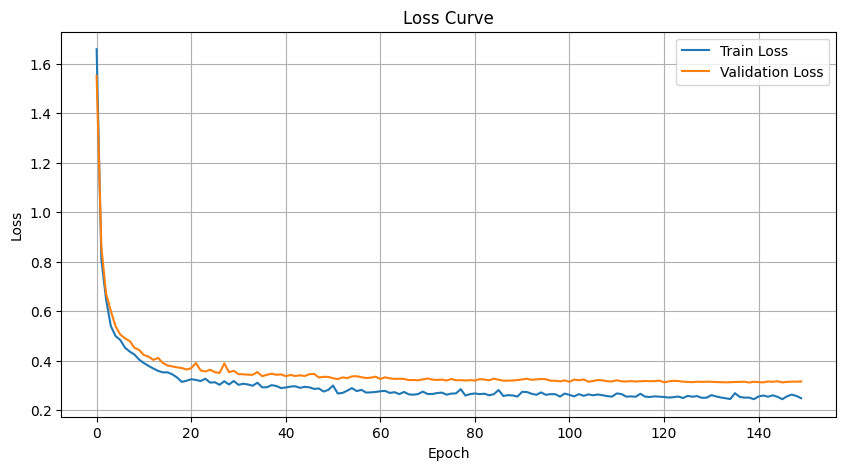

Best validation loss: 0.3118


In [58]:
# Visualize training progress
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

print(f"Best validation loss: {best_val_loss:.4f}")


## Section 6: Model Evaluation
This section evaluates the trained model on the test set, calculates quantitative metrics (PSNR, SSIM, MAE), and visualizes prediction results.

Evaluation Metrics:
MAE (Mean Absolute Error): Average pixel-wise difference, lower is better
PSNR (Peak Signal-to-Noise Ratio): Image quality metric in dB, higher is better (>30dB is good)
SSIM (Structural Similarity Index): Perceptual similarity metric, closer to 1 is better

## Download Pre-trained Model

In [35]:
import os
import sys

# Install gdown if not available
try:
    import gdown
except ImportError:
    print("Installing gdown...")
    import subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "gdown"])
    import gdown

# Create checkpoints directory
os.makedirs('checkpoints', exist_ok=True)

# Download from Google Drive
file_id = '1JYA8ZIY6EXcOl4R3yWjG77g2aEuzSpMQ'
url = f'https://drive.google.com/uc?id={file_id}'
output = 'checkpoints/best_model.pth'

print("Downloading pre-trained model...")
gdown.download(url, output, quiet=False)

print("Done")


Downloading...
From (original): https://drive.google.com/uc?id=1JYA8ZIY6EXcOl4R3yWjG77g2aEuzSpMQ
From (redirected): https://drive.google.com/uc?id=1JYA8ZIY6EXcOl4R3yWjG77g2aEuzSpMQ&confirm=t&uuid=78f0c36f-e943-4bfe-a30d-0b391ad8f02c
To: /home/s5820023/Desktop/test/checkpoints/best_model.pth
100%|████████████████████████████████████████████████████████████████████████████| 377M/377M [00:03<00:00, 98.3MB/s]


Done


In [36]:
import torch
from pathlib import Path

# Load best model
checkpoint_path = Path("checkpoints/best_model.pth")
model = SimpleUNet(in_channels=3, out_channels=3, base_channels=64)

checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

print(f"✓ Model loaded from epoch {checkpoint['epoch']}")
print(f"  Validation loss: {checkpoint['val_loss']:.4f}")


✓ Model loaded from epoch 143
  Validation loss: 0.3041


### Quantitative Evaluation

In [38]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

# Test on test set
psnr_list = []
ssim_list = []
mae_list = []

model.eval()
with torch.no_grad():
    for raw, basecolor in test_loader:
        raw = raw.to(device)
        basecolor = basecolor.to(device)
        
        output = model(raw)
        
        for i in range(len(raw)):
            pred = output[i].cpu().permute(1, 2, 0).numpy()
            target = basecolor[i].cpu().permute(1, 2, 0).numpy()
            
            pred = np.clip(pred, 0, 1)
            target = np.clip(target, 0, 1)
            
            psnr_list.append(psnr(target, pred, data_range=1.0))
            ssim_list.append(ssim(target, pred, multichannel=True, channel_axis=2, data_range=1.0))
            mae_list.append(np.mean(np.abs(target - pred)))


print("TEST SET RESULTS")
print(f"PSNR: {np.mean(psnr_list):.2f} dB")
print(f"SSIM: {np.mean(ssim_list):.4f}")
print(f"MAE:  {np.mean(mae_list):.6f}")


TEST SET RESULTS
PSNR: 27.52 dB
SSIM: 0.8988
MAE:  0.038937


### Qualitative Evaluation 

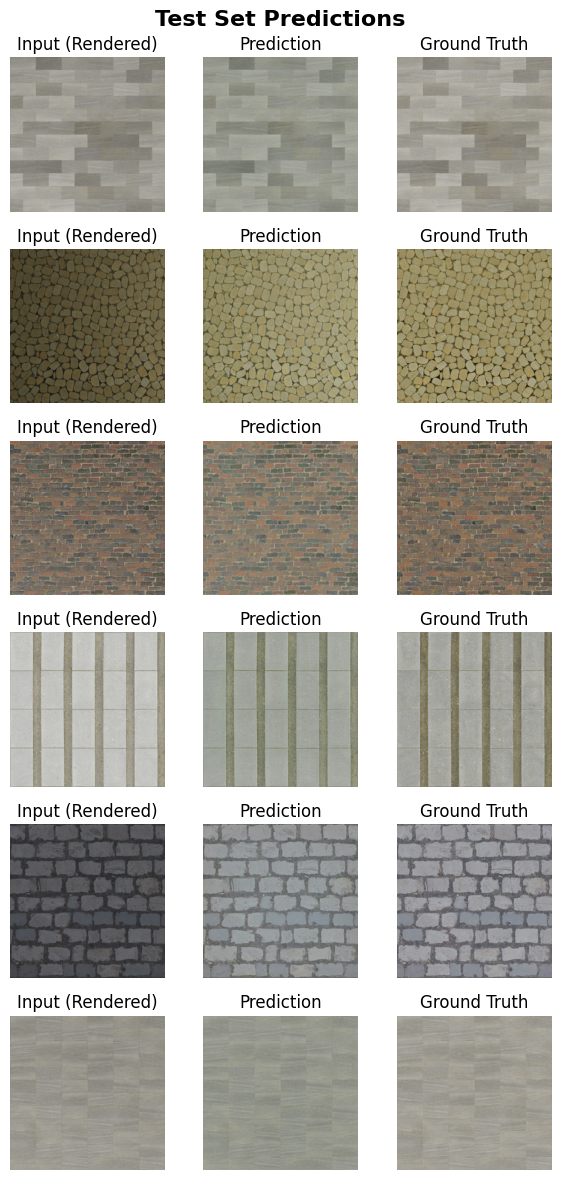

In [40]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(6, 3, figsize=(6, 12))

model.eval()
sample_count = 0

with torch.no_grad():
    for raw, basecolor in test_loader:
        raw = raw.to(device)
        output = model(raw)
        
        for i in range(len(raw)):
            if sample_count >= 6:
                break
            
            input_img = raw[i].cpu().permute(1, 2, 0).numpy()
            pred_img = output[i].cpu().permute(1, 2, 0).numpy()
            target_img = basecolor[i].cpu().permute(1, 2, 0).numpy()
            
            input_img = np.clip(input_img, 0, 1)
            pred_img = np.clip(pred_img, 0, 1)
            target_img = np.clip(target_img, 0, 1)
            
            axes[sample_count, 0].imshow(input_img)
            axes[sample_count, 0].set_title("Input (Rendered)")
            axes[sample_count, 0].axis('off')
            
            axes[sample_count, 1].imshow(pred_img)
            axes[sample_count, 1].set_title("Prediction")
            axes[sample_count, 1].axis('off')
            
            axes[sample_count, 2].imshow(target_img)
            axes[sample_count, 2].set_title("Ground Truth")
            axes[sample_count, 2].axis('off')
            
            sample_count += 1
        
        if sample_count >= 6:
            break

plt.suptitle("Test Set Predictions", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()



## Single Image Inference 改自己的

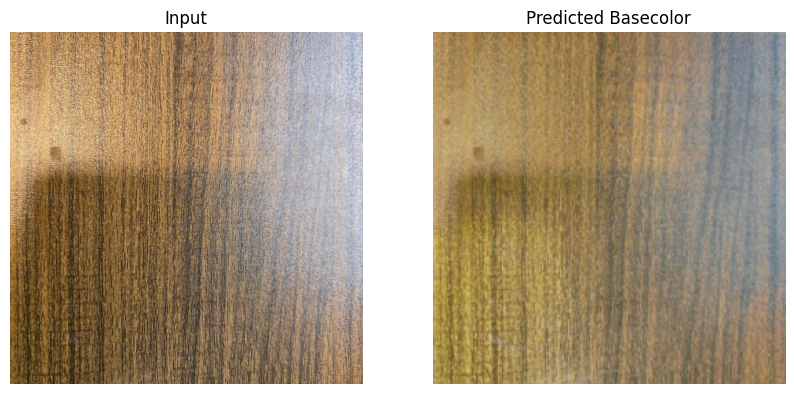

In [54]:
from PIL import Image
import torchvision.transforms as transforms

def predict_single_image(model, image_path, device='cuda'):

    # Load and preprocess
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor()
    ])
    
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(device)
    
    # Predict
    with torch.no_grad():
        output = model(input_tensor)
    
    # Convert to PIL Image
    output_img = output.squeeze(0).cpu()
    output_img = transforms.ToPILImage()(output_img)
    
    return output_img

# Test on a sample
test_image_path = sorted(Path("Test_custom image").glob("*.jpg"))[0]
result = predict_single_image(model, test_image_path, device=device)

# Display
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(Image.open(test_image_path))
axes[0].set_title("Input")
axes[0].axis('off')
axes[1].imshow(result)
axes[1].set_title("Predicted Basecolor")
axes[1].axis('off')
plt.show()



## Section 8: Model Unit Testing
The test suite includes three core tests:

Model Architecture Test: Verifies the model can be instantiated correctly

Forward Pass Test: Validates input/output shape consistency

Parameter Count Test: Ensures the model has the expected number of parameters

In [53]:
! pytest

============================= test session starts ==============================
platform linux -- Python 3.13.11, pytest-9.0.2, pluggy-1.6.0
rootdir: /home/s5820023/Desktop/test
plugins: anyio-4.12.0
collected 3 items                                                              

test_module.py ...                                                       [100%]

============================== 3 passed in 4.64s ===============================
